In [1]:
# %load_ext autoreload
# %autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "42_add_principal_maker_info"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
import numpy as np

sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')

# maker = pd.read_csv('../../data/maker.csv')
maker = pd.read_csv('../../extract_data/maker_rename.csv')

material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')

#production_place = pd.read_csv('../../data/production_place.csv')
production_place = pd.read_csv('../../extract_data/production_place_rename.csv')

technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
test[cfg['target']] = np.nan
train = pd.read_csv('../../data/train.csv')

# del_non_overlapping_list

In [7]:
del_non_overlapping_list = [
    # 'object_id',
    'art_series_id',
    'title',
    #'description',
    #'long_title',
    'principal_maker',
    'principal_or_first_maker',
    #'sub_title',
    'copyright_holder',
    #'more_title',
    'acquisition_method',
    # 'acquisition_date',
    # 'acquisition_credit_line',
    # 'dating_presenting_date',
    # 'dating_sorting_date',
    'dating_period',
    # 'dating_year_early',
    # 'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

In [8]:
def del_non_overlapping(input_df: pd.DataFrame()):
    # for material
    train_oblect_id = train['object_id'].unique().tolist()
    test_oblect_id = test['object_id'].unique().tolist()

    train_value = set(input_df[input_df['object_id'].isin(train_oblect_id)]['name'].unique().tolist())
    test_value = set(input_df[input_df['object_id'].isin(test_oblect_id)]['name'].unique().tolist())

    common_value_list = list(train_value & test_value)

    return input_df[input_df['name'].isin(common_value_list)]

material = del_non_overlapping(material)
historical_person = del_non_overlapping(historical_person)
object_collection = del_non_overlapping(object_collection)
production_place = del_non_overlapping(production_place)

# Merge Data

In [9]:
group = train.groupby('principal_maker')

agg_df = pd.concat([
    group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
    group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の sub_title を持っているか
    group['dating_sorting_date'].agg(['min', 'max', 'mean']), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
], axis=1)

agg_df.head()

,size,sub_title_num,min,max,mean
principal_maker,,,,,
A. Böeseken,5,5,1858.0,1873.0,1865.8
A. Lutz,1,1,1825.0,1825.0,1825.0
A. Mansuy,2,2,1860.0,1860.0,1860.0
A. Nissen,3,1,1860.0,1860.0,1860.0
A. Roussel,1,1,1905.0,1905.0,1905.0


In [10]:
train = pd.merge(train, 
         agg_df,
         on='principal_maker', 
         how='left')

test = pd.merge(test, 
         agg_df,
         on='principal_maker', 
         how='left')

In [11]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes', 'size', 'sub_title_num', 'min', 'max',
       'mean'],
      dtype='object')

# Feature Enginnering

In [12]:
def create_object_feature(input_df):        
    return input_df['likes'].copy()

create_object_feature(test).head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: likes, dtype: float64

In [13]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]

    return input_df[use_columns].copy()

create_numeric_feature(train).head(2)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0


In [14]:
def create_categorical_feature(input_df):
    use_columns = [
    #'title',
    'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    ]

    return input_df[use_columns].copy()

create_categorical_feature(test)['principal_maker'].head()

0            Bernardus Bruining
1    Jan Antonisz van Ravesteyn
2               Theodoor Koning
3         Théodore van Lelyveld
4                    Jan Luyken
Name: principal_maker, dtype: object

In [15]:
import pycld2 as cld2

def create_lang_info(input_df):
    
    out_df = pd.DataFrame()
    
    out_df["title_lang"] = input_df["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
    return out_df

create_lang_info(train).head(2)

,title_lang
0,un
1,un


In [16]:
import re

def create_maker_feature(input_df):
    # 本当は時間の処理とかすべき。
    merge_df = pd.merge(input_df['principal_maker'], maker, left_on='principal_maker', right_on='name',how='left')
    merge_df = merge_df.fillna('missing')

    def get_year(text: str):
        match = re.search(r'[0-9]{4}', text)
        if match:
            return match.group()
        else:
            return np.nan
        
    def get_month(text: str):
        match = re.search(r'-[0-9]{2}-', text)
        if match:
            return match.group()[1:-1]
        else:
            return np.nan
    
    # year
    merge_df['date_of_birth_year'] = merge_df['date_of_birth'].apply(lambda x : get_year(x)).astype('float')
    merge_df['date_of_death_year'] = merge_df['date_of_death'].apply(lambda x : get_year(x)).astype('float')
    
    # month
    merge_df['date_of_birth_month'] = merge_df['date_of_birth'].apply(lambda x : get_month(x)).astype('float')
    merge_df['date_of_death_month'] = merge_df['date_of_death'].apply(lambda x : get_month(x)).astype('float')
    
    del_list = [
        'Unnamed: 0',
        'place_of_birth',
        'place_of_death',
        'principal_maker',
        'date_of_birth',
        'date_of_death'
    ]
    
    merge_df = merge_df.drop(del_list,axis=1)
    
    return merge_df

create_maker_feature(train).head(2)

,name,nationality,place_of_birth_country_name,place_of_death_country_name,date_of_birth_year,date_of_death_year,date_of_birth_month,date_of_death_month
0,Jan Hackaert,missing,Netherlands,Netherlands,1628.0,1705.0,NaN,NaN
1,Richard Tepe,missing,Netherlands,Netherlands,1864.0,1952.0,NaN,NaN


In [17]:
def create_material_feature(input_df):
    
    out_df = pd.DataFrame()

    material_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_w2v.csv')
    material_collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_w2v.csv')
    material_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_technique_w2v.csv')
    material_collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_w2v.csv')
    material_collection_technique_production_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_w2v.csv')
    material_collection_technique_production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], material_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]

create_material_feature(train).head(2)

,material_w2v_0,material_w2v_1,material_w2v_2,material_w2v_3,material_w2v_4,material_w2v_5,material_w2v_6,material_w2v_7,material_w2v_8,material_w2v_9,...,material_collection_technique_production_country_w2v_20,material_collection_technique_production_country_w2v_21,material_collection_technique_production_country_w2v_22,material_collection_technique_production_country_w2v_23,material_collection_technique_production_country_w2v_24,material_collection_technique_production_country_w2v_25,material_collection_technique_production_country_w2v_26,material_collection_technique_production_country_w2v_27,material_collection_technique_production_country_w2v_28,material_collection_technique_production_country_w2v_29
0,0.278293,-0.231511,-0.662789,0.991121,0.265224,0.322988,0.102308,-0.456635,-0.190513,-0.944719,...,-0.322543,-0.111608,0.591859,-0.245983,-0.657963,-0.485101,-1.523239,0.461789,0.381441,0.069295
1,0.588832,1.351733,-0.972135,0.362667,-0.376671,-1.124974,0.475698,0.625674,0.555431,-0.876702,...,0.479570,0.600997,-0.478906,-0.229830,1.112767,-0.622317,-0.249008,-0.773201,0.224783,-0.254743


In [18]:
def create_object_collection_feature(input_df):
    collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_w2v.csv')
    collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, collection_technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_object_collection_feature(train).head(2)

,collection_w2v_0,collection_w2v_1,collection_w2v_2,collection_technique_w2v_0,collection_technique_w2v_1,collection_technique_w2v_2,collection_technique_w2v_3,collection_technique_w2v_4,collection_technique_w2v_5,collection_technique_w2v_6,collection_technique_w2v_7,collection_technique_w2v_8,collection_technique_w2v_9
0,-0.649585,-0.883449,1.056636,-0.802673,-0.773696,2.710698,0.041548,-0.239502,-0.667183,-0.838723,-0.637467,0.571580,-0.086521
1,NaN,NaN,NaN,-0.155195,-0.252811,0.461979,0.062138,-0.218526,-0.039926,-0.068988,-0.283977,0.272564,-0.126860


In [19]:
def create_technique_feature(input_df):
    technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_technique_feature(train).head(2)

,technique_w2v_0,technique_w2v_1,technique_w2v_2,technique_w2v_3,technique_w2v_4,technique_w2v_5,technique_w2v_6,technique_w2v_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.230237,-0.075641,0.27766,-0.29013,-0.180698,0.399966,0.128924,-0.01231


In [20]:
def create_historical_person_feature(input_df):
    vc = historical_person['name'].value_counts()
    
    # 出現回数30以上に絞る
    use_names = vc[vc >= 30].index
    
    # isin で 30 回以上でてくるようなレコードに絞り込んでから crosstab を行なう
    idx = historical_person['name'].isin(use_names)
    historical_person_only_famous = historical_person[idx].reset_index(drop=True)
    #print(historical_person_only_famous)
        
    cross_historical_person = pd.crosstab(historical_person_only_famous['object_id'], historical_person_only_famous['name']).reset_index()
    
    input_historical_person = pd.merge(input_df['object_id'], cross_historical_person, on='object_id',how='left')
    input_historical_person.columns = [col.replace(',','') for col in input_historical_person.columns]
    return input_historical_person.iloc[:,1:].add_prefix('HistoricalPerson_')
  
create_historical_person_feature(train).head(2)

,HistoricalPerson_Djatiroto Suikeronderneming,HistoricalPerson_Frederik Hendrik (prins van Oranje),HistoricalPerson_Handels Vereeniging Amsterdam,HistoricalPerson_Jacobus II (koning van Engeland en Schotland),HistoricalPerson_Lodewijk XIV (koning van Frankrijk),HistoricalPerson_Maria II Stuart (koningin van Engeland Schotland en Ierland),HistoricalPerson_Maurits (prins van Oranje),HistoricalPerson_Musschenbroek Sam van,HistoricalPerson_Oldenbarnevelt Johan van,HistoricalPerson_Ruyter Michiel Adriaansz. de,...,HistoricalPerson_Wilhelm II (keizer van Duitsland),HistoricalPerson_Wilhelmina (koningin der Nederlanden),HistoricalPerson_Willem I (prins van Oranje),HistoricalPerson_Willem III (koning der Nederlanden),HistoricalPerson_Willem III (prins van Oranje en koning van Engeland Schotland en Ierland),HistoricalPerson_Willem V (prins van Oranje-Nassau),HistoricalPerson_Wirix F.J.,HistoricalPerson_Witt Cornelis de,HistoricalPerson_Witt Johan de,HistoricalPerson_Álvarez de Toledo Fernando (3e hertog van Alva)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def create_production_place_feature(input_df):

    out_df = pd.DataFrame()

    prodcution_w2v = pd.read_csv('../../../my_pipeline/extract_data/prodcution_w2v.csv')
    production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], prodcution_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:].add_prefix('ProductionPlace_')
  
create_production_place_feature(test).head(2)

,ProductionPlace_production_w2v_0,ProductionPlace_production_w2v_1,ProductionPlace_production_w2v_2,ProductionPlace_production_w2v_3,ProductionPlace_production_w2v_4,ProductionPlace_production_w2v_5,ProductionPlace_production_w2v_6,ProductionPlace_production_w2v_7,ProductionPlace_production_w2v_8,ProductionPlace_production_w2v_9,...,ProductionPlace_production_country_w2v_10,ProductionPlace_production_country_w2v_11,ProductionPlace_production_country_w2v_12,ProductionPlace_production_country_w2v_13,ProductionPlace_production_country_w2v_14,ProductionPlace_production_country_w2v_15,ProductionPlace_production_country_w2v_16,ProductionPlace_production_country_w2v_17,ProductionPlace_production_country_w2v_18,ProductionPlace_production_country_w2v_19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def create_principle_maker_feature(input_df):

    out_df = pd.DataFrame()

    qualification_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_w2v.csv')
    roles_w2v = pd.read_csv('../../../my_pipeline/extract_data/roles_w2v.csv')
    name_w2v = pd.read_csv('../../../my_pipeline/extract_data/name_w2v.csv')
    qualification_roles_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_roles_w2v.csv')
    qualification_name_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_name_w2v.csv')
    roles_name_w2v = pd.read_csv('../../../my_pipeline/extract_data/roles_name_w2v.csv')
    qualification_roles_name_w2v = pd.read_csv('../../../my_pipeline/extract_data/qualification_roles_name_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], qualification_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, roles_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, name_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, qualification_roles_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, qualification_name_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, roles_name_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, qualification_roles_name_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:].add_prefix('PrincipleMaker_')
  
create_principle_maker_feature(test).head(2)

,PrincipleMaker_qualification_w2v_0,PrincipleMaker_qualification_w2v_1,PrincipleMaker_qualification_w2v_2,PrincipleMaker_qualification_w2v_3,PrincipleMaker_qualification_w2v_4,PrincipleMaker_roles_w2v_0,PrincipleMaker_roles_w2v_1,PrincipleMaker_roles_w2v_2,PrincipleMaker_roles_w2v_3,PrincipleMaker_name_w2v_0,...,PrincipleMaker_qualification_roles_name_w2v_20,PrincipleMaker_qualification_roles_name_w2v_21,PrincipleMaker_qualification_roles_name_w2v_22,PrincipleMaker_qualification_roles_name_w2v_23,PrincipleMaker_qualification_roles_name_w2v_24,PrincipleMaker_qualification_roles_name_w2v_25,PrincipleMaker_qualification_roles_name_w2v_26,PrincipleMaker_qualification_roles_name_w2v_27,PrincipleMaker_qualification_roles_name_w2v_28,PrincipleMaker_qualification_roles_name_w2v_29
0,-1.407384,-0.298591,-0.139830,-2.478325,-2.549996,0.014012,-1.426175,-0.515558,-0.309854,-0.957639,...,-0.111333,0.104669,-0.574753,0.149971,-0.063613,0.443261,-0.487553,-0.454911,-0.420477,0.023687
1,-2.742899,0.964579,-3.054511,-0.525887,-0.858646,1.628303,1.329121,1.599065,-2.243798,-0.605292,...,0.562323,-0.676779,0.284721,-0.028127,-0.183849,-0.461864,1.164964,0.868721,-0.258929,0.071831


In [23]:
import datetime

def create_acquisition_feature(input_df):
    out_df = pd.DataFrame()
    
    use_columns = [
        'acquisition_date'
    ]
    
    out_df['year'] = pd.to_datetime(input_df['acquisition_date']).dt.year
    out_df['month'] = pd.to_datetime(input_df['acquisition_date']).dt.month
    out_df['dayofweek'] = pd.to_datetime(input_df['acquisition_date']).dt.dayofweek
    out_df['sum_time'] =  10**10 - pd.to_datetime(input_df['acquisition_date']).view('int') // 10**9
    
    return out_df.add_prefix('AcquisitionDate_')

create_acquisition_feature(train).head(2)

,AcquisitionDate_year,AcquisitionDate_month,AcquisitionDate_dayofweek,AcquisitionDate_sum_time
0,1808.0,1.0,4.0,15112288000
1,2000.0,1.0,5.0,9053315200


In [24]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
        'description',
        'principal_maker',
        'principal_or_first_maker'
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

create_string_length_feature(train).head(2)

,StringLength__title,StringLength__long_title,StringLength__sub_title,StringLength__more_title,StringLength__description,StringLength__principal_maker,StringLength__principal_or_first_maker
0,5,48,39.0,21.0,NaN,12,12
1,5,64,17.0,15.0,NaN,12,12


In [25]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'acquisition_date',
        'acquisition_credit_line',
        #'art_series_id', 
        'principal_maker',
        'principal_or_first_maker',
        'description', 
        'dating_presenting_date',
        'dating_sorting_date',
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'title',
        'long_title',
        'sub_title',
        'copyright_holder',
        'more_title',
    ]

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

create_count_encoding_feature(train).head(2)

,CE_acquisition_method,CE_acquisition_date,CE_acquisition_credit_line,CE_principal_maker,CE_principal_or_first_maker,CE_description,CE_dating_presenting_date,CE_dating_sorting_date,CE_dating_period,CE_dating_year_early,CE_dating_year_late,CE_title,CE_long_title,CE_sub_title,CE_copyright_holder,CE_more_title
0,4253,48.0,NaN,3,3,NaN,3.0,65.0,3005,65.0,30.0,10516,1,1.0,11313,1.0
1,4253,231.0,NaN,180,180,NaN,77.0,321.0,5042,321.0,214.0,10516,1,1.0,180,1.0


In [26]:
# def create_one_hot_encoding(input_df):
#     use_columns = [
#         'acquisition_method',
#         'principal_maker'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:

#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = train[column].value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(input_df[column], categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

# create_one_hot_encoding(train).head(2)

In [27]:
import re

#  h 166mm × w 78/54mm

def get_h_from_subtitle(text:str):
    match_cm = re.search(r'h \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'h \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100

def get_w_from_subtitle(text:str):
    match_cm = re.search(r'w \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'w \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        elif match_mm.group()[2:-2] == '78/54':
            return float(78)
        else:
            return float(match_mm.group()[2:-2])/100    

def get_t_from_subtitle(text:str):
    match_cm = re.search(r't \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r't \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   

def get_d_from_subtitle(text:str):
    match_cm = re.search(r'd \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'd \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   
        
def create_subtitle_info(input_df):
    out_df = pd.DataFrame()
     
    out_df['subtitle_h'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_h_from_subtitle(x))
    out_df['subtitle_w'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_w_from_subtitle(x))
    out_df['subtitle_t'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_t_from_subtitle(x))
    out_df['subtitle_d'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_d_from_subtitle(x))
    
    out_df['area'] = out_df['subtitle_h'] * out_df['subtitle_w']
    out_df['volume'] = out_df['subtitle_h'] * out_df['subtitle_w'] * out_df['subtitle_t']

    return out_df

create_subtitle_info(test).head(2)

,subtitle_h,subtitle_w,subtitle_t,subtitle_d,area,volume
0,1.67,1.08,NaN,NaN,1.8036,NaN
1,29.70,24.10,NaN,NaN,715.7700,NaN


In [28]:
from util import use_pca

def create_description_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_description_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('DescriptionEmb_')

create_description_emb(test).tail(2)

,DescriptionEmb_pca_0,DescriptionEmb_pca_1,DescriptionEmb_pca_2,DescriptionEmb_pca_3,DescriptionEmb_pca_4,DescriptionEmb_pca_5,DescriptionEmb_pca_6,DescriptionEmb_pca_7,DescriptionEmb_pca_8,DescriptionEmb_pca_9,...,DescriptionEmb_pca_246,DescriptionEmb_pca_247,DescriptionEmb_pca_248,DescriptionEmb_pca_249,DescriptionEmb_pca_250,DescriptionEmb_pca_251,DescriptionEmb_pca_252,DescriptionEmb_pca_253,DescriptionEmb_pca_254,DescriptionEmb_pca_255
12006,4.868668,-2.158481,0.022857,0.005380,-0.005051,-0.033196,-0.030381,0.001403,-0.000757,-0.003157,...,-0.000064,-0.000067,-0.000091,0.000008,0.000044,-0.000033,0.000201,0.000045,-0.000024,-0.000100
12007,-2.857192,-0.279424,-1.757069,-0.255253,-0.783501,-0.267247,-0.262805,-0.261656,0.870815,-0.289136,...,-0.001994,-0.026316,0.001796,-0.004356,0.023299,0.019852,0.020951,0.001647,0.005704,0.004972


In [29]:
from util import use_pca

def create_longtitle_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_longtitle_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('LongTitleEmb_')

create_longtitle_emb(train).tail(2)

,LongTitleEmb_pca_0,LongTitleEmb_pca_1,LongTitleEmb_pca_2,LongTitleEmb_pca_3,LongTitleEmb_pca_4,LongTitleEmb_pca_5,LongTitleEmb_pca_6,LongTitleEmb_pca_7,LongTitleEmb_pca_8,LongTitleEmb_pca_9,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
12024,0.134985,0.274562,-0.355269,-0.568043,0.490877,-0.759765,0.800043,0.492068,-0.684610,-0.055678,...,-0.124074,-0.109663,0.011206,0.033923,-0.071635,0.004939,0.036290,-0.151617,0.046685,0.075895
12025,3.315138,0.391916,-0.387958,-0.729402,-0.963970,-1.700653,-0.560265,0.077447,0.027752,-0.265692,...,0.011086,-0.019667,0.018910,-0.077004,-0.060062,-0.031613,0.043291,0.041124,0.057003,0.006189


In [30]:
# train_emb_df = pd.read_csv('../../extract_data/train_all_more_title_emb.csv').iloc[:,1:]
# test_emb_df = pd.read_csv('../../extract_data/test_all_more_title_emb.csv').iloc[:,1:]
# all_emb_df = pd.concat([train_emb_df, test_emb_df],axis=0).reset_index(drop=True)
# all_emb_df.to_pickle('../../extract_data/all_more_title_emb.pkl')

In [31]:
from util import use_pca

def create_moretitle_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_more_title_emb.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('MongTitleEmb_')

create_moretitle_emb(train).tail(2)

,MongTitleEmb_pca_0,MongTitleEmb_pca_1,MongTitleEmb_pca_2,MongTitleEmb_pca_3,MongTitleEmb_pca_4,MongTitleEmb_pca_5,MongTitleEmb_pca_6,MongTitleEmb_pca_7,MongTitleEmb_pca_8,MongTitleEmb_pca_9,...,MongTitleEmb_pca_246,MongTitleEmb_pca_247,MongTitleEmb_pca_248,MongTitleEmb_pca_249,MongTitleEmb_pca_250,MongTitleEmb_pca_251,MongTitleEmb_pca_252,MongTitleEmb_pca_253,MongTitleEmb_pca_254,MongTitleEmb_pca_255
12024,-1.621602,0.495788,0.815646,-0.214588,0.590383,0.147129,-0.756363,-0.784881,-0.389976,0.249820,...,-0.010943,0.035664,0.038953,0.105053,0.102388,-0.115908,-0.065081,0.116761,-0.162842,0.092758
12025,5.888203,-2.353538,-0.045900,-1.240266,0.274434,-1.162376,-0.212999,-1.767910,0.654541,0.568982,...,-0.101878,0.113013,-0.002954,-0.082443,-0.005041,0.223538,0.038994,-0.017456,0.282542,-0.102775


In [32]:
def create_palette_feature(input_df):
    output_df = input_df.copy()

    # ratio最大のものを取得
    max_palette = palette.groupby('object_id')['ratio'].max().reset_index()
    max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
    max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df['object_id'], max_palette, on="object_id", how="left")

    # 平均のrgbを取得
    mean_palette = palette.copy()
    mean_palette["color_r"] = palette["ratio"] * palette["color_r"]
    mean_palette["color_g"] = palette["ratio"] * palette["color_g"]
    mean_palette["color_b"] = palette["ratio"] * palette["color_b"]
    mean_palette = mean_palette.groupby("object_id").sum().reset_index().rename(
        columns={"color_r":"mean_palette_r", "color_g":"mean_palette_g","color_b":"mean_palette_b"})
    output_df = pd.merge(output_df, mean_palette, on="object_id", how="left")
    
    # rgbの標準偏差を取得
    var_palette = palette.groupby('object_id')[['color_r','color_g','color_b']].std().reset_index().reset_index().rename(
        columns={"color_r":"var_palette_r", "color_g":"var_palette_g","color_b":"var_palette_b"})
    output_df = pd.merge(output_df, var_palette, on="object_id", how="left")

#     # color_rの情報を取得
#     palette_rank_df = palette.copy()
#     palette_rank_df['ratio_rank'] = palette.groupby('object_id', sort=False)["ratio"].apply(lambda x: x.rank(method='first')).astype('int')
    
#     def get_color(palette_rank_df: pd.DataFrame(), output_df: pd.DataFrame, color_name: str, prefix_nanme: str):
#         palette_rank_df = palette_rank_df.pivot(index='object_id', columns='ratio_rank', values=color_name).add_prefix(prefix_nanme).reset_index(drop=False)
#         return  pd.merge(output_df, palette_rank_df, on="object_id", how="left")
        
#     output_df = get_color(palette_rank_df, output_df, color_name= 'color_r', prefix_nanme='ColorR_')
#     output_df = get_color(palette_rank_df, output_df, color_name= 'color_g', prefix_nanme='ColorG_')
#     output_df = get_color(palette_rank_df, output_df, color_name= 'color_b', prefix_nanme='ColorB_')

#     output_df = output_df.drop('ratio',axis=1)
#     output_df = output_df.drop('index_x',axis=1)
#     output_df = output_df.drop('index_y',axis=1)

    return output_df.iloc[:,1:].add_prefix('Palette_')

create_palette_feature(train).head(2)

,Palette_index_x,Palette_max_ratio,Palette_max_palette_r,Palette_max_palette_g,Palette_max_palette_b,Palette_ratio,Palette_mean_palette_r,Palette_mean_palette_g,Palette_mean_palette_b,Palette_index_y,Palette_var_palette_r,Palette_var_palette_g,Palette_var_palette_b
0,2.0,0.108754,54.0,30.0,5.0,1.0,80.760794,52.411413,10.170802,2.0,41.500978,34.432694,16.243813
1,3.0,0.095855,70.0,51.0,42.0,1.0,93.112586,68.715265,56.557897,3.0,30.799625,27.169661,21.839636


In [33]:
# from util import use_pca

# def create_image_feature(input_df):
#     out_df = pd.DataFrame()
    
#     all_image_feature = pd.read_pickle('../../extract_data/all_image_feature.pkl').reset_index(drop='True')

#     all_image_feature_256 = use_pca(all_image_feature.iloc[:,1:], 256)
#     all_emb_df_256 = pd.concat([all_image_feature['object_id'], all_image_feature_256], axis=1)
    
#     input_image_feature = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
#     return input_image_feature.iloc[:,1:].add_prefix('ImageFeature_')

# create_image_feature(test).head()

In [34]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [35]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_object_feature,
        create_numeric_feature,
        create_categorical_feature,
        create_lang_info,
        create_maker_feature,
        #create_historical_person_feature,
        create_material_feature,
        create_object_collection_feature,
        create_technique_feature,
        create_production_place_feature,
        create_principle_maker_feature,
        create_acquisition_feature,
        create_palette_feature,
        ### create_principal_maker_info_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        #create_one_hot_encoding,
        create_subtitle_info,
        create_description_emb,
        create_longtitle_emb,
        create_moretitle_emb
        #create_image_feature
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

train_feat= to_feature(train)
test_feat = to_feature(test)

train = train_feat.copy()
test = test_feat.copy()

 28%|██▊       | 5/18 [00:00<00:00, 35.43it/s]

createcreate_object_feature  0.001[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.057[s]
createcreate_maker_feature  0.064[s]


 39%|███▉      | 7/18 [00:00<00:01,  7.66it/s]

createcreate_material_feature  0.640[s]
createcreate_object_collection_feature  0.062[s]
createcreate_technique_feature  0.037[s]


 50%|█████     | 9/18 [00:01<00:01,  8.17it/s]

createcreate_production_place_feature  0.120[s]


 56%|█████▌    | 10/18 [00:01<00:01,  4.11it/s]

createcreate_principle_maker_feature  0.491[s]
createcreate_acquisition_feature  0.016[s]


 67%|██████▋   | 12/18 [00:02<00:01,  3.86it/s]

createcreate_palette_feature  0.485[s]
createcreate_string_length_feature  0.027[s]
createcreate_count_encoding_feature  0.061[s]


 83%|████████▎ | 15/18 [00:02<00:00,  5.24it/s]

createcreate_subtitle_info  0.088[s]


 89%|████████▉ | 16/18 [00:03<00:01,  1.82it/s]

createcreate_description_emb  1.298[s]


 94%|█████████▍| 17/18 [00:05<00:00,  1.27it/s]

createcreate_longtitle_emb  1.266[s]


  0%|          | 0/18 [00:00<?, ?it/s]

createcreate_moretitle_emb  2.407[s]
createcreate_object_feature  0.000[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.054[s]


 28%|██▊       | 5/18 [00:00<00:00, 35.12it/s]

createcreate_maker_feature  0.069[s]


 39%|███▉      | 7/18 [00:00<00:01,  7.56it/s]

createcreate_material_feature  0.642[s]
createcreate_object_collection_feature  0.065[s]
createcreate_technique_feature  0.039[s]


 50%|█████     | 9/18 [00:01<00:01,  7.93it/s]

createcreate_production_place_feature  0.130[s]


 56%|█████▌    | 10/18 [00:01<00:02,  4.00it/s]

createcreate_principle_maker_feature  0.504[s]
createcreate_acquisition_feature  0.017[s]


 67%|██████▋   | 12/18 [00:02<00:01,  3.72it/s]

createcreate_palette_feature  0.505[s]
createcreate_string_length_feature  0.035[s]


 78%|███████▊  | 14/18 [00:02<00:00,  4.57it/s]

createcreate_count_encoding_feature  0.069[s]
createcreate_subtitle_info  0.092[s]


 89%|████████▉ | 16/18 [00:03<00:01,  1.85it/s]

createcreate_description_emb  1.253[s]


 94%|█████████▍| 17/18 [00:05<00:00,  1.26it/s]

createcreate_longtitle_emb  1.304[s]


100%|██████████| 18/18 [00:08<00:00,  2.20it/s]

createcreate_moretitle_emb  2.736[s]


In [36]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [37]:
# train.to_csv('../EDA/train_for_EDA.csv')
# test.to_csv('../EDA/test_for_EDA.csv')

# train

In [38]:
train.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,MongTitleEmb_pca_246,MongTitleEmb_pca_247,MongTitleEmb_pca_248,MongTitleEmb_pca_249,MongTitleEmb_pca_250,MongTitleEmb_pca_251,MongTitleEmb_pca_252,MongTitleEmb_pca_253,MongTitleEmb_pca_254,MongTitleEmb_pca_255
0,48,17,1660.0,1685.0,other,Jan Hackaert,Jan Hackaert,missing,purchase,un,...,-0.146763,-0.379196,-0.164622,-0.078697,-0.234489,-0.011775,-0.077729,-0.130692,0.154506,0.170745
1,2,19,1900.0,1930.0,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase,un,...,0.042216,0.087050,-0.064330,0.026390,-0.047565,-0.049652,0.075816,0.056409,0.029483,0.154736


In [39]:
# import collections

# collections.Counter(train.columns.tolist())

In [40]:
test.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,MongTitleEmb_pca_246,MongTitleEmb_pca_247,MongTitleEmb_pca_248,MongTitleEmb_pca_249,MongTitleEmb_pca_250,MongTitleEmb_pca_251,MongTitleEmb_pca_252,MongTitleEmb_pca_253,MongTitleEmb_pca_254,MongTitleEmb_pca_255
0,NaN,19,1850.0,1900.0,other,Bernardus Bruining,Bernardus Bruining,missing,transfer,un,...,-0.111191,0.066091,0.019139,-0.044325,-0.000441,-0.032629,0.008489,0.064118,-0.028514,0.132997
1,NaN,17,1609.0,1633.0,other,Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,missing,nationalization 1795,un,...,0.051996,0.068485,0.048602,0.187217,-0.090821,-0.159858,-0.094763,0.248662,-0.093518,-0.182917


# reduce mem usage

In [41]:
from util import reduce_mem_usage
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 26.93 Mb (66.8% reduction)
Mem. usage decreased to 26.97 Mb (66.7% reduction)


# del_non_overlapping 2

In [42]:
train, test = replace_non_overlap_val_to_missing(train,test,columns=['title_lang'])

# Lable Encoding

In [43]:
cat_col = train.select_dtypes('O').columns.tolist()

In [44]:
cat_col

['art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name']

In [45]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [46]:
train.dtypes

likes                     int16
dating_period              int8
dating_year_early       float16
dating_year_late        float16
art_series_id             int64
                         ...   
MongTitleEmb_pca_251    float16
MongTitleEmb_pca_252    float16
MongTitleEmb_pca_253    float16
MongTitleEmb_pca_254    float16
MongTitleEmb_pca_255    float16
Length: 1141, dtype: object

# add fold

In [47]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Target Encoding

In [48]:
target_enc_list = [
    # 'title',
    # 'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    'dating_period',
    'title_lang'
]

from fe import target_encoding
train, test = target_encoding(train, 
                              test, 
                              target = cfg['target'], 
                              target_enc_list = target_enc_list, 
                              fold_num = cfg['fold_num']
                             )

principal_maker
principal_or_first_maker
copyright_holder
acquisition_method
dating_period
title_lang


# Make Model

In [49]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [50]:
use_col

['dating_period',
 'dating_year_early',
 'dating_year_late',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name',
 'date_of_birth_year',
 'date_of_death_year',
 'date_of_birth_month',
 'date_of_death_month',
 'material_w2v_0',
 'material_w2v_1',
 'material_w2v_2',
 'material_w2v_3',
 'material_w2v_4',
 'material_w2v_5',
 'material_w2v_6',
 'material_w2v_7',
 'material_w2v_8',
 'material_w2v_9',
 'material_w2v_10',
 'material_w2v_11',
 'material_w2v_12',
 'material_w2v_13',
 'material_w2v_14',
 'material_w2v_15',
 'material_w2v_16',
 'material_w2v_17',
 'material_w2v_18',
 'material_w2v_19',
 'material_collection_w2v_0',
 'material_collection_w2v_1',
 'material_collection_w2v_2',
 'material_collection_w2v_3',
 'material_collection_w2v_4',
 'material_collection_w2v_5',
 'material_collection_w2v_6',
 'material_collection_w2v_7',


In [51]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)
# e99ecbcc2d9a775a09280213a06af1cf174d0fe0

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [52]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance(PLOT=False)

--------------FOLDS : 0 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anac

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17356	valid_1's rmse: 1.20908
[200]	training's rmse: 1.00624	valid_1's rmse: 1.08705
[300]	training's rmse: 0.933373	valid_1's rmse: 1.05573
[400]	training's rmse: 0.881042	valid_1's rmse: 1.04199
[500]	training's rmse: 0.837138	valid_1's rmse: 1.03331
[600]	training's rmse: 0.7989	valid_1's rmse: 1.02816
[700]	training's rmse: 0.764095	valid_1's rmse: 1.02317
[800]	training's rmse: 0.732466	valid_1's rmse: 1.01866
[900]	training's rmse: 0.703209	valid_1's rmse: 1.01563
[1000]	training's rmse: 0.676239	valid_1's rmse: 1.01289
[1100]	training's rmse: 0.650824	valid_1's rmse: 1.01062
[1200]	training's rmse: 0.627164	valid_1's rmse: 1.00902
[1300]	training's rmse: 0.605217	valid_1's rmse: 1.00732
[1400]	training's rmse: 0.584372	valid_1's rmse: 1.00556
[1500]	training's rmse: 0.564587	valid_1's rmse: 1.00442
[1600]	training's rmse: 0.545856	valid_1's rmse: 1.00315
[1700]	training's rmse: 0.528346	valid_

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anac

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.16781	valid_1's rmse: 1.21853
[200]	training's rmse: 0.999734	valid_1's rmse: 1.10499
[300]	training's rmse: 0.927393	valid_1's rmse: 1.07817
[400]	training's rmse: 0.876111	valid_1's rmse: 1.06617
[500]	training's rmse: 0.832837	valid_1's rmse: 1.05758
[600]	training's rmse: 0.794442	valid_1's rmse: 1.05157
[700]	training's rmse: 0.759853	valid_1's rmse: 1.04691
[800]	training's rmse: 0.728294	valid_1's rmse: 1.04217
[900]	training's rmse: 0.699032	valid_1's rmse: 1.03872
[1000]	training's rmse: 0.671504	valid_1's rmse: 1.03605
[1100]	training's rmse: 0.646093	valid_1's rmse: 1.03356
[1200]	training's rmse: 0.622627	valid_1's rmse: 1.03127
[1300]	training's rmse: 0.600137	valid_1's rmse: 1.03023
[1400]	training's rmse: 0.57931	valid_1's rmse: 1.02886
[1500]	training's rmse: 0.559511	valid_1's rmse: 1.02746
[1600]	training's rmse: 0.540867	valid_1's rmse: 1.02692
[1700]	training's rmse: 0.523001	vali

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anac

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17425	valid_1's rmse: 1.20746
[200]	training's rmse: 1.008	valid_1's rmse: 1.09036
[300]	training's rmse: 0.936433	valid_1's rmse: 1.05945
[400]	training's rmse: 0.884608	valid_1's rmse: 1.04518
[500]	training's rmse: 0.840967	valid_1's rmse: 1.03582
[600]	training's rmse: 0.80235	valid_1's rmse: 1.02983
[700]	training's rmse: 0.767146	valid_1's rmse: 1.02408
[800]	training's rmse: 0.735117	valid_1's rmse: 1.02013
[900]	training's rmse: 0.705743	valid_1's rmse: 1.01681
[1000]	training's rmse: 0.678301	valid_1's rmse: 1.01357
[1100]	training's rmse: 0.652977	valid_1's rmse: 1.01084
[1200]	training's rmse: 0.628999	valid_1's rmse: 1.0088
[1300]	training's rmse: 0.606772	valid_1's rmse: 1.00719
[1400]	training's rmse: 0.585705	valid_1's rmse: 1.00616
[1500]	training's rmse: 0.565884	valid_1's rmse: 1.00442
[1600]	training's rmse: 0.547108	valid_1's rmse: 1.00327
[1700]	training's rmse: 0.529404	valid_1'

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anac

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.16861	valid_1's rmse: 1.23009
[200]	training's rmse: 1.00018	valid_1's rmse: 1.11737
[300]	training's rmse: 0.92745	valid_1's rmse: 1.08798
[400]	training's rmse: 0.876142	valid_1's rmse: 1.075
[500]	training's rmse: 0.83287	valid_1's rmse: 1.06628
[600]	training's rmse: 0.794225	valid_1's rmse: 1.05975
[700]	training's rmse: 0.759322	valid_1's rmse: 1.05515
[800]	training's rmse: 0.727314	valid_1's rmse: 1.05049
[900]	training's rmse: 0.698371	valid_1's rmse: 1.04729
[1000]	training's rmse: 0.67124	valid_1's rmse: 1.04393
[1100]	training's rmse: 0.646068	valid_1's rmse: 1.04126
[1200]	training's rmse: 0.622225	valid_1's rmse: 1.03845
[1300]	training's rmse: 0.599937	valid_1's rmse: 1.03668
[1400]	training's rmse: 0.57902	valid_1's rmse: 1.03496
[1500]	training's rmse: 0.559223	valid_1's rmse: 1.03317
[1600]	training's rmse: 0.540501	valid_1's rmse: 1.0318
[1700]	training's rmse: 0.522834	valid_1's r

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/shinichiro.saito/opt/anac

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17238	valid_1's rmse: 1.2176
[200]	training's rmse: 1.00526	valid_1's rmse: 1.09324
[300]	training's rmse: 0.931846	valid_1's rmse: 1.06201
[400]	training's rmse: 0.879296	valid_1's rmse: 1.04861
[500]	training's rmse: 0.835245	valid_1's rmse: 1.03899
[600]	training's rmse: 0.796356	valid_1's rmse: 1.03271
[700]	training's rmse: 0.761198	valid_1's rmse: 1.02781
[800]	training's rmse: 0.729498	valid_1's rmse: 1.02405
[900]	training's rmse: 0.699848	valid_1's rmse: 1.02032
[1000]	training's rmse: 0.672349	valid_1's rmse: 1.01728
[1100]	training's rmse: 0.646737	valid_1's rmse: 1.01519
[1200]	training's rmse: 0.622954	valid_1's rmse: 1.0135
[1300]	training's rmse: 0.600633	valid_1's rmse: 1.01201
[1400]	training's rmse: 0.579614	valid_1's rmse: 1.01021
[1500]	training's rmse: 0.559795	valid_1's rmse: 1.0089
[1600]	training's rmse: 0.541383	valid_1's rmse: 1.00804
[1700]	training's rmse: 0.523875	valid_1

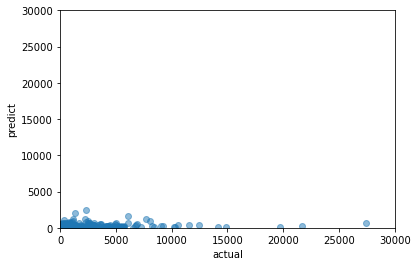

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(train['likes'],lgbm.oof,alpha=0.5);
plt.xlim(0,30000);
plt.ylim(0,30000);
plt.xlabel('actual');
plt.ylabel('predict');

In [54]:
train[train['likes'] < 50]

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,MongTitleEmb_pca_253,MongTitleEmb_pca_254,MongTitleEmb_pca_255,fold,principal_maker_target_enc,principal_or_first_maker_target_enc,copyright_holder_target_enc,acquisition_method_target_enc,dating_period_target_enc,title_lang_target_enc
0,48,17,1660.0,1685.0,0,638,638,25,6,13,...,-0.130737,0.154541,0.170776,0,34.000000,34.000000,84.717660,93.411989,166.412056,81.003403
1,2,19,1900.0,1930.0,0,1042,1041,23,6,13,...,0.056396,0.029480,0.154785,0,12.470588,12.470588,12.470588,93.411989,54.370800,81.003403
2,5,19,1860.0,1880.0,0,1202,1212,25,2,10,...,0.052612,-0.026825,0.051544,0,159.857923,158.856244,84.717660,62.250801,54.370800,4.427848
4,7,19,1825.0,1874.0,0,1194,1194,25,8,13,...,0.018021,0.157227,-0.005955,0,22.865972,23.358289,84.717660,11.147402,54.370800,81.003403
5,0,19,1867.0,1867.0,0,174,175,25,2,13,...,-0.106445,0.073242,0.016464,0,3.000000,3.000000,84.717660,62.250801,54.370800,81.003403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12020,6,20,1935.0,1936.0,0,1194,1194,25,6,13,...,0.051239,0.166748,-0.017258,4,23.889527,24.341410,83.251353,90.179818,36.716475,77.494111
12021,4,19,1900.0,1920.0,0,295,296,25,7,13,...,-0.005905,-0.097473,0.032196,4,NaN,NaN,83.251353,20.151635,58.355755,77.494111
12022,0,18,1701.0,1714.0,0,13,13,25,6,13,...,-0.135864,-0.020935,0.045685,4,0.444444,0.444444,83.251353,90.179818,55.729022,77.494111
12023,0,18,1778.0,1778.0,0,916,915,25,7,13,...,-0.068298,-0.025635,0.060974,4,1.000000,1.000000,83.251353,20.151635,55.729022,77.494111


In [55]:
os.makedirs(f"{OUTPUT_DIR}/imp", exist_ok=True)
feature_importance_df[order[:50]].to_csv(f"{OUTPUT_DIR}/imp/importance.csv")
display(feature_importance_df[order[:50]])

,material_collection_technique_w2v_19,material_collection_technique_w2v_3,material_collection_w2v_19,principal_maker,material_collection_technique_production_country_w2v_3,subtitle_h,principal_or_first_maker,material_collection_technique_production_country_w2v_7,PrincipleMaker_roles_w2v_3,principal_or_first_maker_target_enc,...,material_technique_w2v_10,StringLength__description,MongTitleEmb_pca_23,MongTitleEmb_pca_2,AcquisitionDate_year,LongTitleEmb_pca_1,DescriptionEmb_pca_13,collection_technique_w2v_7,StringLength__sub_title,MongTitleEmb_pca_3
fold_0,148431.925512,175162.160846,75191.891612,34867.548003,22046.114965,11866.108602,17889.954002,25230.191467,8354.239990,20290.066264,...,2759.687867,1657.482021,1776.234689,2345.327678,1039.877932,2203.090243,1329.488022,1031.146136,1805.464694,1145.597707
fold_1,119229.825811,210732.185570,91979.170516,31408.287188,8206.509330,14237.856034,23240.341801,18251.046490,13986.619873,20466.344690,...,1825.415679,1702.771819,1118.438884,2261.357948,689.799952,3079.601894,1057.304746,3126.187178,1028.362459,903.680289
fold_2,48154.811361,181001.835887,11630.036480,28525.355436,16355.688887,21648.452963,28949.473881,32516.489810,22513.740234,20272.330523,...,3291.682255,1875.158571,1334.311829,2326.907594,805.624315,2182.582355,1831.855104,10212.102545,1873.810991,1356.611594
fold_3,138771.727288,144269.052387,46546.838336,33860.961639,9671.062015,12098.767521,26613.389594,8226.333926,33263.448608,17619.350402,...,1475.074168,1453.151786,1745.767594,1660.117810,1254.598724,2888.350348,2126.741657,12862.396521,1375.810357,1162.972968
fold_4,240173.382567,84817.450337,73464.026446,32981.778600,24958.547007,24308.732835,24276.323368,21585.151225,20350.661133,18234.936066,...,1994.170549,1980.517676,1883.626926,1835.739109,1807.813258,1739.208577,1701.864626,1673.595841,1672.103528,1656.734878


In [56]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [57]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [58]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [59]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210311005408_42_add_principal_maker_info/pred/pred_likes_1.0076.csv


In [60]:
sub_df.describe()

,likes
count,12008.000000
mean,21.095419
std,63.056282
min,0.000000
25%,1.012958
50%,2.435223
75%,6.385180
max,2102.699617


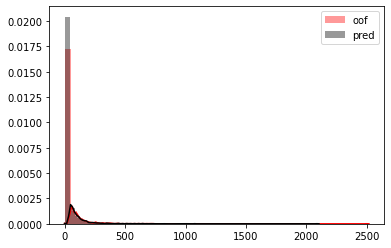

In [61]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)